This notebook exists to show the method used to find a 1D CNN that worked for this problem as well as providing an easy place to produce figures for the report. I started off using only one channel for simplicity however the resulting model was not learning enough to get over the problems caused by a skewed database, even when I weighted the classes accordingly. I belived I needed more data or that the model I was using was too big, (too many paramters). So I then looked into adding augmented data into the training set, through mirroring, scaling and shifting as well as reducing the size of the model through its hyperparameters. However this was still not enough. I then thought I might aswell chuck all the data I have at it so combined all 6 channels into one long array and used that. This lead to a model with much better performance!!!!

Most of the hyperparameters used here have been tuned mainly through trial and error.

In [26]:
from database.data import Data

#used to encoded strings to binary 
from sklearn.preprocessing import LabelEncoder

#used for cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#used for class weighting
from sklearn.utils import class_weight

import numpy as np

In [27]:
#defining train split ratio
train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3

#creating DATA object
ptb_binary_NN = Data(database = 'ptbdb', denoise_method=None, estimation_method = 'NN', train_splits=train_splits, binary = True, parameterisation = False)

#running preprocessing
ptb_binary_NN.run()

Filtering Database


 20%|█▉        | 109/549 [00:13<00:55,  7.89it/s]


KeyboardInterrupt: 

In [3]:
#just using 1 channel for now (0)
X_train = ptb_binary_NN.split_data[0]['X_train']
y_train = ptb_binary_NN.split_data[0]['y_train']

X_test = ptb_binary_NN.split_data[0]['X_test']
y_test = ptb_binary_NN.split_data[0]['y_test']

In [4]:
#as data set is small we can augment new data types, i.e. shift/mirror

def time_shift(data, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

def scale_data(data, scale_factor=0.1):
    scale = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    augmented_data = data * scale
    return augmented_data

def augment_data(data):
    augmented_data = []
    for signal in data:
        augmented_data.append(signal)
        augmented_data.append(time_shift(signal))
        augmented_data.append(scale_data(signal))
    return np.array(augmented_data)

In [5]:
X_train_aug = augment_data(X_train)
X_test_aug = augment_data(X_test)

#need to increase the size of the corresponding class data 
y_train_aug = np.tile(y_train, 3)
y_test_aug = np.tile(y_test, 3)

In [6]:
# NN needs encoded labels (1s and 0s) to perform comparissons and calculate probabilities 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_aug)
y_test_encoded = label_encoder.transform(y_test_aug)

In [7]:
#CNN needs to know number of features per sample, i.e. 1D
X_train_cnn = np.expand_dims(X_train_aug, axis=-1) 
y_train_cnn = np.expand_dims(y_train_encoded, axis=-1) 
X_test_cnn = np.expand_dims(X_test_aug, axis=-1) 
y_test_cnn = np.expand_dims(y_test_encoded, axis=-1) 

In [8]:
#shows shape of arrays and also can see the skewed classes
print(X_train_cnn.shape)
print(X_test_cnn.shape)
print(y_test_cnn.shape)


print(sum(y_test_cnn))

(411, 60000, 1)
(177, 60000, 1)
(177, 1)
[138]


In [9]:
#finding class weight due to inbalanced class system
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_test_aug), y=y_test_aug)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.269230769230769, 1: 0.6413043478260869}


In [10]:
# Define hyperparameters - find out what should be - currently done through trial and error
DEPTH = 1  #number of convolutional layers
FILTERS = 8  #number of filters in each layer
k = 3  # kernel size

# initialise model
cnn = Sequential()

for _ in range(DEPTH):
    cnn.add(Conv1D(filters=FILTERS, kernel_size=k, padding='same', input_shape = (60000, 1)))#each signal is always 60000 samples long
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling1D(pool_size=3))  # takes max out of every three, also regularisation
    cnn.add(Dropout(0.5)) #used for regularisation, removes certain percentage of samples each time

cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))  # use 'softmax' for multi-class classification, 'sigmoid' for binary classification

# build/compile empty model
cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) #binary cross entropy for binary classification

#allows you to see the model is built properly
print(cnn.summary())

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60000, 8)       │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60000, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       160,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 160,049 (625.19 KB)

 Non-trainable params: 16 (64.00 B)

None


In [11]:
#fitting the model whilst keeping track of the history for later use

history = cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20, #number of repeats 
    batch_size=16,
    validation_data=(X_test_cnn, y_test_cnn),
    class_weight=class_weights_dict #weights training data
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.5289 - loss: 12.2222 - val_accuracy: 0.6102 - val_loss: 0.7567
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.5063 - loss: 6.8007 - val_accuracy: 0.5650 - val_loss: 1.1272
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.6965 - loss: 4.7524 - val_accuracy: 0.3842 - val_loss: 1.1829
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7363 - loss: 2.2205 - val_accuracy: 0.4124 - val_loss: 1.6119
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.7119 - loss: 1.9677 - val_accuracy: 0.2994 - val_loss: 2.0657
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.7144 - loss: 2.1336 - val_accuracy: 0.2373 - val_loss: 2.9094
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6987 - loss: 1.6983 - val_accuracy: 0.6949 - val_loss: 0.6725
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7102 - loss: 1.8394 - val_accuracy: 0

In [12]:
#we can see that this is limited as there is not enough data to overcome the class inblance, accuracy = class inbalnce
loss, accuracy = cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6102 - loss: 0.6778
Validation loss: 0.6770959496498108
Validation accuracy: 0.6101694703102112


The above has resulted in a model that has only guessed positive or negative, after considerable fine tuning of parameters to no avail, I believe this to be due to not enough data so below is a repeat with all the data.

In [13]:
#maybe limited by amount of data so instead lets try using all the data available, i.e. all 6 channels

#first combining all channels into one long array
X_train_all = []
X_test_all = []
y_train_all = []
y_test_all = []

for i in range(6):
    print(ptb_binary_NN.split_data[i]['X_train'].shape)
    X_train_all.append(ptb_binary_NN.split_data[i]['X_train'])
    y_train_all.append(ptb_binary_NN.split_data[i]['y_train'])

    X_test_all.append(ptb_binary_NN.split_data[i]['X_test'])
    y_test_all.append(ptb_binary_NN.split_data[i]['y_test'])


(137, 60000)
(123, 60000)
(112, 60000)
(126, 60000)
(144, 60000)
(141, 60000)


In [14]:
#flattenign arrays into one long uninterupted list
X_train_all_list = [element for array in X_train_all for element in array]
y_train_all_list = [element for array in y_train_all for element in array]
X_test_all_list = [element for array in X_test_all for element in array]
y_test_all_list = [element for array in y_test_all for element in array]

print(len(X_train_all_list))
print(len(X_test_all_list))
#now have alot more data points

783
337


In [15]:
#encoding y labels 
label_encoder = LabelEncoder()
y_train_all_encoded = label_encoder.fit_transform(y_train_all_list)
y_test_all_encoded = label_encoder.transform(y_test_all_list)

In [16]:
#changing into format appropriate for CNN
#CNN needs to know number of features per sample, i.e. 1D
X_train_all_cnn = np.expand_dims(X_train_all_list, axis=-1) 
y_train_all_cnn = np.expand_dims(y_train_all_encoded, axis=-1) 
X_test_all_cnn = np.expand_dims(X_test_all_list, axis=-1) 
y_test_all_cnn = np.expand_dims(y_test_all_encoded, axis=-1) 

In [17]:
print(X_train_all_cnn.shape)
print(X_test_all_cnn.shape)
print(y_test_all_cnn.shape)


print(sum(y_test_all_cnn))

(783, 60000, 1)
(337, 60000, 1)
(337, 1)
[264]


In [18]:
#finding class weight due to inbalanced class system
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_all_list), y=y_train_all_list)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 2.2761627906976742, 1: 0.6407528641571195}


In [19]:
# Define hyperparameters - find out what should be??
DEPTH = 2  #number of convolutional layers
FILTERS = 16  #number of filters in each layer
k = 3  # kernel size

# initialise model
cnn = Sequential()

for _ in range(DEPTH):
    cnn.add(Conv1D(filters=FILTERS, kernel_size=k, padding='same', input_shape = (60000, 1)))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling1D(pool_size=2))  # takes max out of every two
    cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))  # use 'softmax' for multi-class classification, 'sigmoid' for binary classification

# Compile the model
cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) #binary cross entropy for binary classification

print(cnn.summary())

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 60000, 16)      │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60000, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 60000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30000, 16)      │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30000, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 30000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 240000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       240,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,977 (941.32 KB)

 Trainable params: 240,913 (941.07 KB)

 Non-trainable params: 64 (256.00 B)

None


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
#implementing early stopping regularisation

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn.fit(
    X_train_all_cnn, y_train_all_cnn,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_all_cnn, y_test_all_cnn),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.5968 - loss: 4.3231 - val_accuracy: 0.3472 - val_loss: 1.6197
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.7069 - loss: 1.9741 - val_accuracy: 0.5282 - val_loss: 0.6980
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.8057 - loss: 2.6671 - val_accuracy: 0.7122 - val_loss: 1.3735
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.8244 - loss: 2.1775 - val_accuracy: 0.8012 - val_loss: 0.4627
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 542ms/step - accuracy: 0.9098 - loss: 0.8723 - val_accuracy: 0.6172 - val_loss: 1.2454
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.8919 - loss: 0.8996 - val_accuracy: 0.8487 - val_loss: 0.4046
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - accuracy: 0.9304 - loss: 0.9037 - val_accuracy: 0.8220 - val_loss: 1.2653
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 473ms/step - accuracy: 0.8948 - loss: 2.2596 - val_accu

In [25]:
loss, accuracy = cnn.evaluate(X_test_all_cnn, y_test_all_cnn)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9251 - loss: 0.1459
Validation loss: 0.14426124095916748
Validation accuracy: 0.9406528472900391


In [22]:
from sklearn.metrics import classification_report

y_pred = cnn.predict(X_test_all_cnn)

threshold = 1-np.sum(y_test_all_encoded)/len(y_test_all_encoded)

y_pred_classes = (y_pred > threshold).astype(int)

print(classification_report(y_test_all_encoded, y_pred_classes))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
              precision    recall  f1-score   support

           0       0.94      0.68      0.79        73
           1       0.92      0.99      0.95       264

    accuracy                           0.92       337
   macro avg       0.93      0.84      0.87       337
weighted avg       0.92      0.92      0.92       337



[]

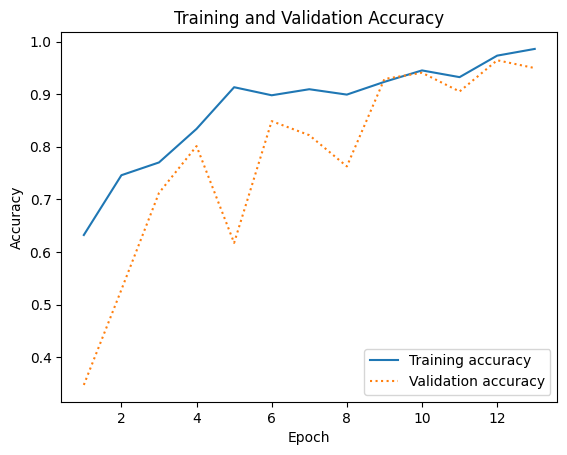

In [23]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('figures\\train_vs_val_acc.png', bbox_inches='tight')
plt.plot()

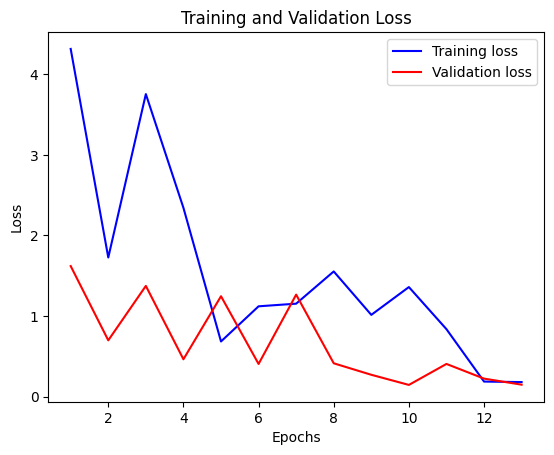

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val = history.history['val_accuracy']

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('figures\\train_vs_val_loss.png', bbox_inches='tight')
plt.legend()